In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
def check_trend_line(support: bool, pivot: int, slope: float, y: np.array):
    # compute sum of differences between line and prices, 
    # return negative val if invalid 
    
    # Find the intercept of the line going through pivot point with given slope
    intercept = -slope * pivot + y[pivot]
    line_vals = slope * np.arange(len(y)) + intercept
     
    diffs = line_vals - y
    
    # Check to see if the line is valid, return -1 if it is not valid.
    if support and diffs.max() > 1e-5:
        return -1.0
    elif not support and diffs.min() < -1e-5:
        return -1.0

    # Squared sum of diffs between data and line 
    err = (diffs ** 2.0).sum()
    return err;

In [6]:
def optimize_slope(support: bool, pivot:int , init_slope: float, y: np.array):
    
    # Amount to change slope by. Multiplyed by opt_step
    slope_unit = (y.max() - y.min()) / len(y) 
    
    # Optmization variables
    opt_step = 1.0
    min_step = 0.0001
    curr_step = opt_step # current step
    
    # Initiate at the slope of the line of best fit
    best_slope = init_slope
    best_err = check_trend_line(support, pivot, init_slope, y)
    assert(best_err >= 0.0) # Shouldn't ever fail with initial slope

    get_derivative = True
    derivative = None
    while curr_step > min_step:

        if get_derivative:
            # Numerical differentiation, increase slope by very small amount
            # to see if error increases/decreases. 
            # Gives us the direction to change slope.
            slope_change = best_slope + slope_unit * min_step
            test_err = check_trend_line(support, pivot, slope_change, y)
            derivative = test_err - best_err;
            
            # If increasing by a small amount fails, 
            # try decreasing by a small amount
            if test_err < 0.0:
                slope_change = best_slope - slope_unit * min_step
                test_err = check_trend_line(support, pivot, slope_change, y)
                derivative = best_err - test_err

            if test_err < 0.0: # Derivative failed, give up
                raise Exception("Derivative failed. Check your data. ")

            get_derivative = False

        if derivative > 0.0: # Increasing slope increased error
            test_slope = best_slope - slope_unit * curr_step
        else: # Increasing slope decreased error
            test_slope = best_slope + slope_unit * curr_step
        

        test_err = check_trend_line(support, pivot, test_slope, y)
        if test_err < 0 or test_err >= best_err: 
            # slope failed/didn't reduce error
            curr_step *= 0.5 # Reduce step size
        else: # test slope reduced error
            best_err = test_err 
            best_slope = test_slope
            get_derivative = True # Recompute derivative
    
    # Optimize done, return best slope and intercept
    return (best_slope, -best_slope * pivot + y[pivot])

In [7]:
def fit_trendlines_single(data: np.array):
    # find line of best fit (least squared) 
    # coefs[0] = slope,  coefs[1] = intercept 
    x = np.arange(len(data))
    coefs = np.polyfit(x, data, 1)

    # Get points of line.
    line_points = coefs[0] * x + coefs[1]

    # Find upper and lower pivot points
    upper_pivot = (data - line_points).argmax() 
    lower_pivot = (data - line_points).argmin() 
   
    # Optimize the slope for both trend lines
    support_coefs = optimize_slope(True, lower_pivot, coefs[0], data)
    resist_coefs = optimize_slope(False, upper_pivot, coefs[0], data)

    return (support_coefs, resist_coefs) 

In [8]:
def fit_trendlines_high_low(high: np.array, low: np.array, close: np.array):
    x = np.arange(len(close))
    coefs = np.polyfit(x, close, 1)
    # coefs[0] = slope,  coefs[1] = intercept
    line_points = coefs[0] * x + coefs[1]
    upper_pivot = (high - line_points).argmax() 
    lower_pivot = (low - line_points).argmin() 
    
    support_coefs = optimize_slope(True, lower_pivot, coefs[0], low)
    resist_coefs = optimize_slope(False, upper_pivot, coefs[0], high)

    return (support_coefs, resist_coefs)

In [16]:
# Load data
SRC_DATA_FILENAME = 'data/EURUSD_D1.csv'
data = pd.read_csv(SRC_DATA_FILENAME)
data['Date'] = data['Date'].astype('datetime64[s]')
data = data.set_index('Date')

# Trendline parameter
lookback = 30


support_slope = [np.nan] * len(data)
resist_slope = [np.nan] * len(data)
for i in range(lookback - 1, len(data)):
    candles = data.iloc[i - lookback + 1: i + 1]
    support_coefs, resist_coefs =  fit_trendlines_high_low(candles['High'], candles['Low'], candles['Close'])
    support_slope[i] = support_coefs[0]
    resist_slope[i] = resist_coefs[0]

data['support_slope'] = support_slope
data['resist_slope'] = resist_slope

/tmp/ipykernel_25168/3319262477.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept = -slope * pivot + y[pivot]
/tmp/ipykernel_25168/231065477.py:56: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return (best_slope, -best_slope * pivot + y[pivot])


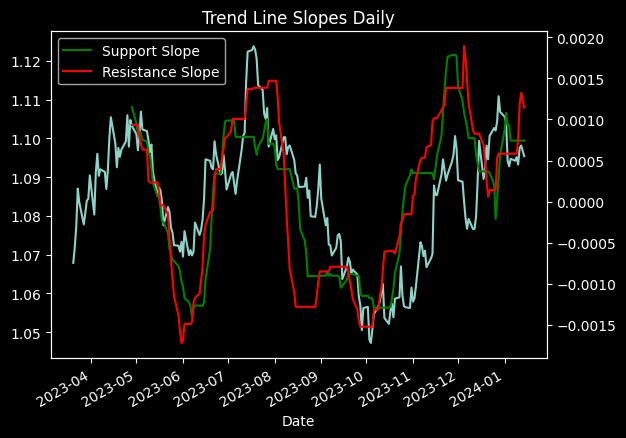

In [10]:
plt.style.use('dark_background')
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
data['Close'].plot(ax=ax1)
data['support_slope'].plot(ax=ax2, label='Support Slope', color='green')
data['resist_slope'].plot(ax=ax2, label='Resistance Slope', color='red')
plt.title("Trend Line Slopes Daily")
plt.legend()
plt.show()

/tmp/ipykernel_25168/3319262477.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept = -slope * pivot + y[pivot]
/tmp/ipykernel_25168/231065477.py:56: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return (best_slope, -best_slope * pivot + y[pivot])


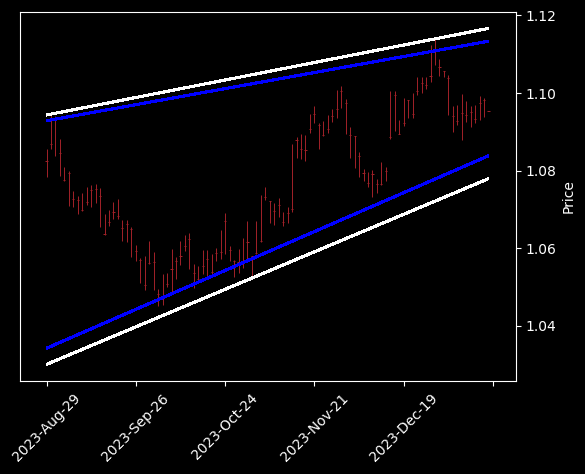

In [18]:
import mplfinance as mpf 



candles = data.tail(100) # Last 30 candles in data
support_coefs_c, resist_coefs_c = fit_trendlines_single(candles['Close'])
support_coefs, resist_coefs = fit_trendlines_high_low(candles['High'], candles['Low'], candles['Close'])

support_line_c = support_coefs_c[0] * np.arange(len(candles)) + support_coefs_c[1]
resist_line_c = resist_coefs_c[0] * np.arange(len(candles)) + resist_coefs_c[1]

support_line = support_coefs[0] * np.arange(len(candles)) + support_coefs[1]
resist_line = resist_coefs[0] * np.arange(len(candles)) + resist_coefs[1]

plt.style.use('dark_background')
ax = plt.gca()

def get_line_points(candles, line_points):
    # Place line points in tuples for matplotlib finance
    # https://github.com/matplotlib/mplfinance/blob/master/examples/using_lines.ipynb
    idx = candles.index
    line_i = len(candles) - len(line_points)
    assert(line_i >= 0)
    points = []
    for i in range(line_i, len(candles)):
        points.append((idx[i], line_points[i - line_i]))
    return points

s_seq = get_line_points(candles, support_line)
r_seq = get_line_points(candles, resist_line)
s_seq2 = get_line_points(candles, support_line_c)
r_seq2 = get_line_points(candles, resist_line_c)
mpf.plot(candles, alines=dict(alines=[s_seq, r_seq, s_seq2, r_seq2], colors=['w', 'w', 'b', 'b']), type='candle', style='charles', ax=ax)
plt.show()